In [86]:
import numpy as np
from utils import *
import pandas as pd
from sklearn.metrics import confusion_matrix

data = pd.read_table("data/trec_crowd.txt", header=None)
truth = pd.read_table("data/trec_truth.txt", header=None)


In [41]:
import matplotlib.pyplot as plt


In [87]:
truth = truth.drop_duplicates()

In [88]:
truth.groupby(1).count()

,0
1,
1,400
2,400


In [89]:
n, m, k = np.max(np.array(data), axis=0)
print(n, m, k)


800 164 2


In [90]:
labels = transform_data(data)
labels

array([[ 1,  0,  1, ..., -1, -1, -1],
       [ 1,  0,  0, ...,  1,  0,  1],
       [ 1,  0,  1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int64)

In [91]:
ranking = truth.sort_values(1)[0]-1

In [92]:
ranking


399    399
619    619
621    621
345    345
344    344
      ... 
320    320
318    318
317    317
376    376
799    799
Name: 0, Length: 800, dtype: int64

In [66]:
merged = data.merge(truth,on=0)


In [67]:
# proportion of missing values
missing = np.mean(labels == -1)
print(missing)

0.9939058049887934


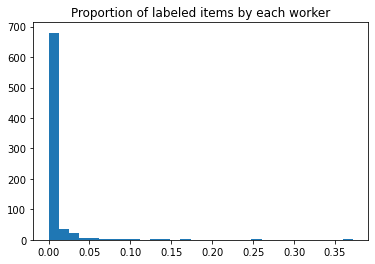

In [68]:
plt.hist(np.mean(labels != -1, axis=1), bins=30)
plt.title("Proportion of labeled items by each worker")
plt.savefig("pic/trec_proportion.png", dpi=300)
plt.show()

In [69]:
# total error rate
error = np.mean(merged["1_y"] != merged[2])
print(error)

0.3879343854466299


In [70]:
merged["error"] = merged["1_y"] != merged[2]
error_worker = merged.groupby(['1_x']).mean()

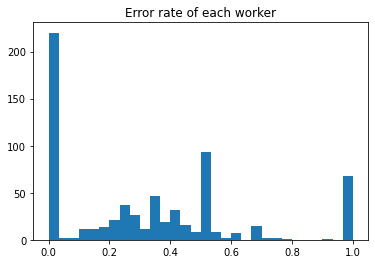

In [71]:
plt.hist(error_worker["error"], bins=30)
plt.title("Error rate of each worker")
plt.savefig("pic/trec_error.png", dpi=300)
plt.show()


In [72]:
error_item = merged.groupby([0]).mean()

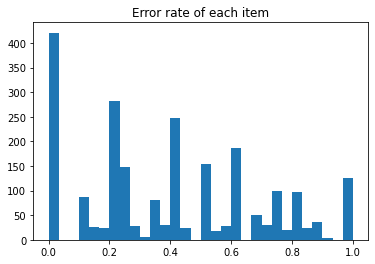

In [73]:
plt.hist(error_item["error"], bins=30)
plt.title("Error rate of each item")
plt.savefig("pic/trec_error_item.png", dpi=300)
plt.show()


In [84]:
confusion_matrix(merged["1_y"], merged[2])


array([[2283, 3250],
       [1740, 5590]], dtype=int64)

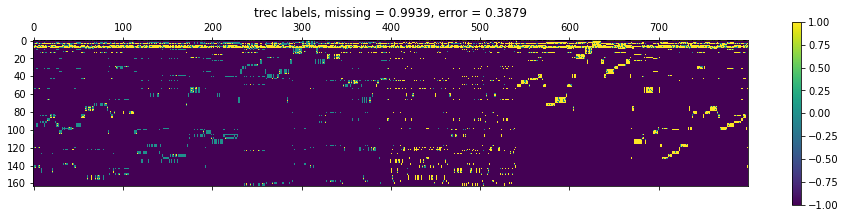

In [93]:
plt.matshow(labels[:, ranking])
plt.title("trec labels, missing = "+str(np.round(missing, 4)) +
          ", error = "+str(np.round(error, 4)))
plt.colorbar()
plt.savefig("pic/trec_labels.png", dpi=300)
plt.show()


In [117]:
def get_confusion_matrix2(k, labels, groups=None, sym=True, cutoff=1e-7, L=50, N=10, seed=None):
    m, n = labels.shape
    if seed is not None:
        np.random.seed(seed)
    if groups is None:
        groups = np.random.randint(3, size=m)
    Zg = get_Zg(k, labels, groups)
    M2s, M3s = get_M(Zg)
    Cc = np.zeros((3, k, k))
    W = np.zeros((3, k))
    for g, (M2, M3) in enumerate(zip(M2s, M3s)):
        Q = get_whiten(M2, sym)
        M3_whiten = whiten_tensor(M3, Q)
        values, vectors = robust_tensor_power(M3_whiten, L, N, sym)
        w = values**-2
        mu = np.linalg.inv(Q.T)@vectors@np.diag(values)
        best = np.argmax(mu, axis=0)

        # prevent multiple mu in same column
        # not_in_best = []
        # not_used_loc = np.array([], dtype=np.int64)
        # for l in range(k):
        #     loc = np.where(best == l)[0]
        #     if len(loc) == 1:
        #         Cc[g, :, l] = mu[:, loc].ravel()
        #         W[g, l] = w[loc]
        #     elif len(loc) == 0:
        #         not_in_best.append(l)
        #     else:
        #         chosen = np.random.randint(len(loc))
        #         Cc[g, :, l] = mu[:, loc[chosen]].ravel()
        #         W[g, l] = w[loc[chosen]]
        #         not_used_loc = np.append(not_used_loc, np.delete(loc, chosen))

        # not_used_loc = np.random.permutation(not_used_loc)
        # for i, l in enumerate(not_in_best):
        #     Cc[g, :, l] = mu[:, not_used_loc[i]].ravel()
        #     W[g, l] = w[not_used_loc[i]]

        # the method in original code
        for h in range(k):
            l = best[h]
            if W[g, l] != 0:
                l = np.where(W[g, :] == 0)[0][0]
            Cc[g, :, l] = mu[:, h].ravel()
            W[g, l] = w[h]

    W = np.mean(W, axis=0)
    C = np.zeros((m, k, k))
    for i in range(m):
        Ca = (np.sum(Cc, axis=0)-Cc[groups[i], :, :])/2
        Za = (np.sum(Zg, axis=0)-Zg[groups[i], :, :])/2
        E = np.zeros((k, k))
        for j in range(n):
            if labels[i, j] != -1:
                E[labels[i, j], :] += Za[j, :]
        E /= n
        Ci = E@np.linalg.inv(W[np.newaxis, :]*Ca.T)
        if cutoff:
            Ci[Ci < cutoff] = cutoff
        colsums = np.sum(Ci, axis=0)
        Ci /= colsums[np.newaxis, :]
        C[i, :, :] = Ci
    return C


In [118]:
C_true = get_true_confusion_matrix(data, truth)


In [119]:
C_true[0]

array([[0.4       , 0.09352518],
       [0.6       , 0.90647482]])

In [120]:
# baseline
confusion_matrix_loss(np.ones(C_true.shape)/k, C_true)

0.1913874662233823

In [121]:
groups = np.array([i%3 for i in range(m)])

In [122]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, groups=groups, sym=True), C_true)


0.25595995684954465

In [123]:
groups_balance = np.random.permutation(groups)

In [124]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, groups=groups_balance,sym=True), C_true)

0.19448618212335242

In [125]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, sym=True, seed=123), C_true)


0.2627873230889457

In [126]:
confusion_matrix_loss(get_confusion_matrix2(
    k, labels, sym=True, seed=123), C_true)


0.2627873230889457

In [130]:
# iterations
maxiter = 100
step = 5
Ls = np.array([i for i in range(step,maxiter+1,step)],dtype=int)
losses = np.zeros(len(Ls))
for i,L in enumerate(Ls):
    print(L)
    losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=L, N=100, seed=123), C_true)


5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


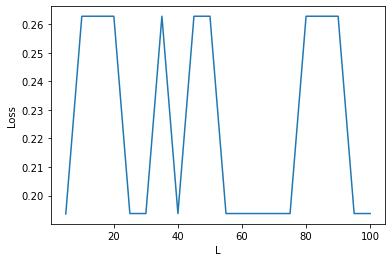

In [131]:
plt.plot(Ls,losses)
plt.xlabel("L")
plt.ylabel("Loss")
plt.savefig("pic/trec_L.png",dpi=300)
plt.show()


In [132]:
# iterations
maxiter = 10
step = 1
Ns = np.array([i for i in range(step, maxiter+1,step)], dtype=int)
losses_N = np.zeros(len(Ns))
for i, N in enumerate(Ns):
    print(N)
    losses_N[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=100, N=N, seed=123), C_true)


1
2
3
4
5
6
7
8
9
10


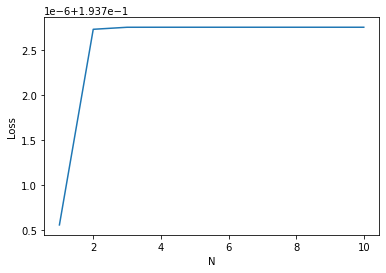

In [133]:
plt.plot(Ns, losses_N)
plt.xlabel("N")
plt.ylabel("Loss")
plt.savefig("pic/trec_N.png", dpi=300)
plt.show()


In [134]:
losses_N

array([0.19370056, 0.19370273, 0.19370275, 0.19370275, 0.19370275,
       0.19370275, 0.19370275, 0.19370275, 0.19370275, 0.19370275])

In [135]:
# symmetric or not
iternum = 100
sym_losses = np.zeros(iternum)
asym_losses = np.zeros(iternum)
for i in range(iternum):
    if i%10==9:
        print(i)
    sym_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=10, N=10), C_true)
    asym_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=False, L=10, N=10), C_true)

9
19
29
39
49
59
69
79
89
99


In [136]:
print(np.min(sym_losses),np.max(sym_losses))
print(np.min(asym_losses), np.max(asym_losses))


0.19111462603583046 0.32562049636829654
0.1713266097158041 0.33081479415547294


In [137]:
np.percentile(np.append(sym_losses, asym_losses),99)


0.32562697801222024

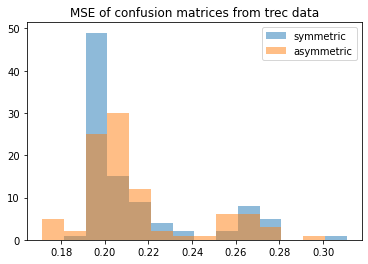

In [141]:
xmin = np.min(np.append(sym_losses,asym_losses))
xmax = np.percentile(np.append(sym_losses, asym_losses), 95)
bins = np.linspace(xmin, xmax, 15)
plt.hist(sym_losses,bins, alpha=0.5, label='symmetric')
plt.hist(asym_losses, bins, alpha=0.5, label='asymmetric')
plt.title("MSE of confusion matrices from trec data")
plt.legend(loc='upper right')
plt.savefig("pic/trec_symmetry.png",dpi=300)
plt.show()


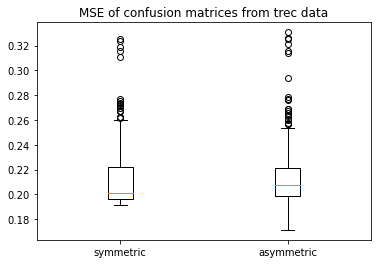

In [139]:
plt.boxplot([sym_losses, asym_losses], labels=['symmetric', 'asymmetric'])
plt.title("MSE of confusion matrices from trec data")
plt.savefig("pic/trec_symmetry_box.png", dpi=300)
plt.show()


From the plot we can see if we symmetricalize the matrices and tensors, the MSE of the confusion matrices can be reduced.

In [142]:
# symmetric or not
iternum = 100
new_losses = np.zeros(iternum)
original_losses = np.zeros(iternum)
for i in range(iternum):
    if i % 10 == 9:
        print(i)
    new_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=10, N=10), C_true)
    original_losses[i] = confusion_matrix_loss(get_confusion_matrix2(
        k, labels, sym=True, L=10, N=10), C_true)


9
19
29
39
49
59
69
79
89
99


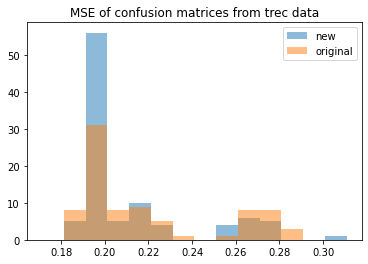

In [143]:
xmin = np.min(np.append(sym_losses, asym_losses))
xmax = np.percentile(np.append(sym_losses, asym_losses), 95)
bins = np.linspace(xmin, xmax, 15)
plt.hist(new_losses, bins, alpha=0.5, label='new')
plt.hist(original_losses, bins, alpha=0.5, label='original')
plt.title("MSE of confusion matrices from trec data")
plt.legend(loc='upper right')
plt.savefig("pic/trec_singular.png",dpi=300)
plt.show()


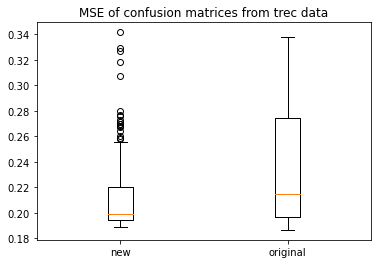

In [144]:
plt.boxplot([new_losses, original_losses], labels=['new', 'original'])
plt.title("MSE of confusion matrices from trec data")
plt.savefig("pic/trec_singular_box.png", dpi=300)
plt.show()


In [145]:
# balance or not
iternum = 100
balance_losses = np.zeros(iternum)
inbalance_losses = np.zeros(iternum)
for i in range(iternum):
    if i % 10 == 9:
        print(i)
    balance_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, groups=np.random.permutation([i % 3 for i in range(m)]), L=10, N=10), C_true)
    inbalance_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=10, N=10), C_true)


9
19
29
39
49
59
69
79
89
99


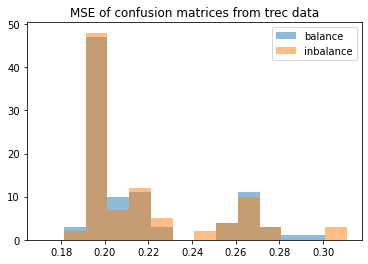

In [146]:
xmin = np.min(np.append(sym_losses, asym_losses))
xmax = np.percentile(np.append(sym_losses, asym_losses), 95)
bins = np.linspace(xmin, xmax, 15)
plt.hist(balance_losses, bins, alpha=0.5, label='balance')
plt.hist(inbalance_losses, bins, alpha=0.5, label='inbalance')
plt.title("MSE of confusion matrices from trec data")
plt.legend(loc='upper right')
# plt.savefig("pic/trec_singular.png",dpi=300)
plt.show()


In [147]:
np.max(balance_losses)

0.32729880909404174

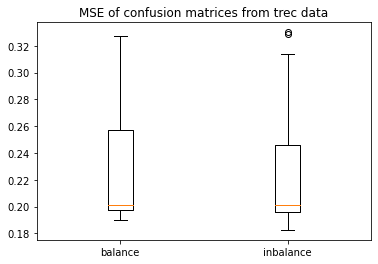

In [148]:
plt.boxplot([balance_losses, inbalance_losses],
            labels=['balance', 'inbalance'])
plt.title("MSE of confusion matrices from trec data")
plt.savefig("pic/trec_balance_box.png", dpi=300)
plt.show()
